In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from nn_interpretability.interpretation.lrp.lrp_composite import LRPMix
from nn_interpretability.model.model_trainer import ModelTrainer
from nn_interpretability.model.model_repository import ModelRepository
from nn_interpretability.uncertainty.evidential_dl import Evidential_DL
from nn_interpretability.visualization.mnist_visualizer import MnistVisualizer
from nn_interpretability.dataset.mnist_data_loader import MnistDataLoader

In [2]:
model_name = 'evidential_cnn.pt'

train = False

In [3]:
mnist_data_loader = MnistDataLoader()

In [4]:
model = ModelRepository.get_general_mnist_cnn(model_name)

if train:
    criterion = Evidential_DL.edl_mse_loss
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)

    model.train()
    ModelTrainer.train_evidence(model, criterion, optimizer, mnist_data_loader.trainloader, epochs=25)
    
    ModelRepository.save(model, model_name)

# I. Evidential Deep Learning
## 1. Test Evidential Deep Learning
Test the model trained on evidential deep learning and check its average evidence and uncertainty on the MNIST test dataset.

In [5]:
Evidential_DL.edl_validate(model, Evidential_DL.edl_mse_loss, mnist_data_loader.testloader)

Average Evidential Deep Learning Test loss: 0.175 | Accuracy: 97.37% | Evidence: 22.872 | Uncertainty: 0.359


# II. Uncertainty Example - Rotated Images

/media/storage/dl_env/bdluam-p4-interpretability-of-nn/implementation/nn_interpretability/visualization/mnist_visualizer.py:83: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_stack = np.hstack(image.squeeze(0).cpu().numpy().reshape(28, 28) for image in images)


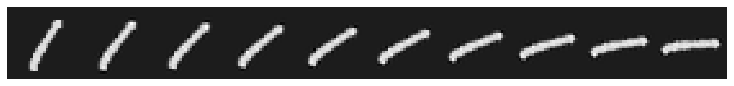

In [6]:
img = mnist_data_loader.get_image_for_class(1).cpu()
rotate_imgs = []
for i in range(0,-60,-6):
    rotate_img = mnist_data_loader.rotate_image(1,i)
    rotate_imgs.append(rotate_img)
    
MnistVisualizer.cat_images(rotate_imgs, 10, 8)

## 1. Prediction of  the evidential deep learning model
If the predicted probability is **10%** it means any class is equally likely and the model answers **I don't know**

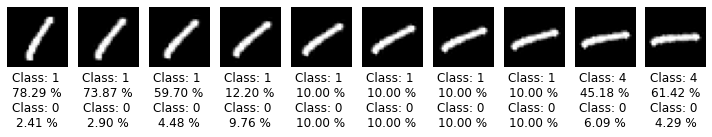

In [7]:
cat_size = torch.Tensor(10,1,28,28)
score, cls = Evidential_DL.predict_class(model, torch.cat(rotate_imgs, out=cat_size), top_k=2)
MnistVisualizer.result_for_each_rotation(rotate_imgs, cls, score, 2, 10, 20)

## 2. Prediction of the evidential deep learning model with uncertainty
After rotating the image to some extend, the model will classify it as another class or the model itself doesn't know which class it belongs. In these cases the uncertainty will remain high.

/media/storage/dl_env/bdluam-p4-interpretability-of-nn/implementation/nn_interpretability/visualization/mnist_visualizer.py:83: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_stack = np.hstack(image.squeeze(0).cpu().numpy().reshape(28, 28) for image in images)


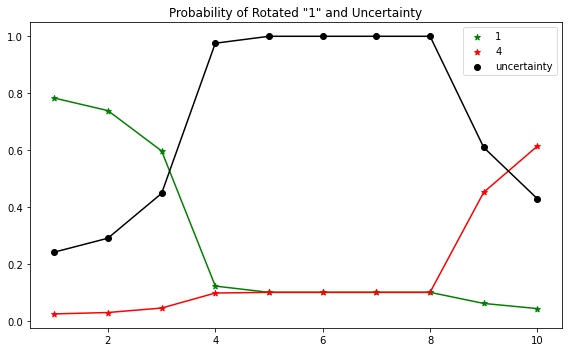

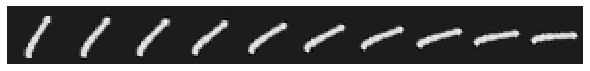

In [8]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)

cls_logits, cls_prob, cls_u = Evidential_DL.edl_predict(model, torch.cat(rotate_imgs, out=cat_size))

plt.figure(figsize=(8, 5))


plt.scatter(np.tile(np.arange(1, 11), cls_prob.shape[0]), cls_prob[:, :, 1].flatten(), \
            c='g', marker='*', linewidth=None, alpha=1, label='1');
plt.plot(np.tile(np.arange(1, 11), cls_prob.shape[0]), cls_prob[:, :, 1].flatten(), c='g')

plt.scatter(np.tile(np.arange(1, 11), cls_prob.shape[0]), cls_prob[:, :, 4].flatten(), \
            c='r', marker='*', linewidth=None, alpha=1, label='4');
plt.plot(np.tile(np.arange(1, 11), cls_prob.shape[0]), cls_prob[:, :, 4].flatten(), c='r')


plt.scatter(np.tile(np.arange(1, 11), cls_logits.shape[0]), cls_u[:, :, :].flatten(), \
            c='k', marker='o', linewidth=None, alpha=1, label='uncertainty');
plt.plot(np.tile(np.arange(1, 11), cls_prob.shape[0]), cls_u[:, :, :].flatten(), c='k')

plt.title('Probability of Rotated "1" and Uncertainty');
plt.legend(framealpha=0.7);
plt.tight_layout();

MnistVisualizer.cat_images(rotate_imgs, 8, 1)

## 3. Use LRP to interpret uncertainty
Here we want to explore how assigning evidence and uncertainty to our nerual network during training will affect the intepretation of our model. We first interpret predictions from base CNN model with `composite LRP`. Then compare interpretated results with the same attributtion method but from the model trained under `evidential deep learning` approach. 

Check out how we use our **nn_interpretability** API by just calling `LRPMix()` and `interpretor.interpret()` two lines!
### 3.1.1 Interpret base model with composite LRP
Here **NO UNCERTAINTY** is introduced

In [9]:
model_name_no_uncertain = 'model_cnn.pt'
model_no_uncertain = ModelRepository.get_general_mnist_cnn(model_name_no_uncertain)

In [10]:
import torch.nn.functional as F
from nn_interpretability.interpretation.lrp.lrp_composite import LRPMix

def prediction_lrp_mix(model, image):
    model.eval()
    image = image.to(Evidential_DL.device)
    # Consturct LRPMix
    interpretor = LRPMix(model, 'predicted', None, 1, 0, 0)
    heatmap = interpretor.interpret(image)
    predicted = interpretor.get_class()
    logits = model(image)
    evd = F.relu(logits)
    alpha = evd + 1
    return heatmap.detach().cpu().numpy(), predicted

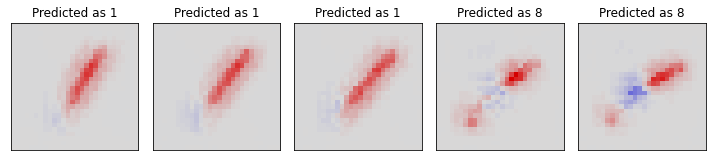

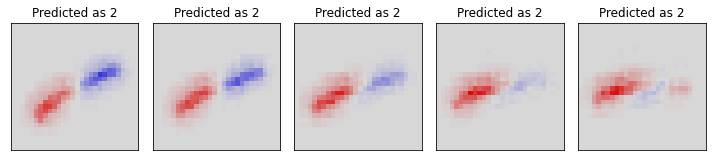

In [11]:
images = []
predicted = []
for i in range(len(rotate_imgs)):
    out, pred = prediction_lrp_mix(model_no_uncertain, rotate_imgs[i])
    images.append(out[0].sum(axis=0))
    predicted.append(pred)

MnistVisualizer.edl_heatmap_for_each_rotation(images, predicted, None)

### 3.1.2 Interpret evidential deep learning model with composite LRP


In [12]:
def uncertain_prediction_lrp_mix(model, image):
    model.eval()
    image = image.to(Evidential_DL.device)
    # Consturct LRPMix
    interpretor = LRPMix(model, 'predicted', None, 1, 0, 0)
    heatmap = interpretor.interpret(image)
    predicted = interpretor.get_class()
    logits = model(image)
    evd = F.relu(logits)
    alpha = evd + 1
    uncertainty = logits.size(1) / torch.sum(alpha, dim=1, keepdim=True)
    return heatmap.detach().cpu().numpy(), predicted, uncertainty.cpu().item()

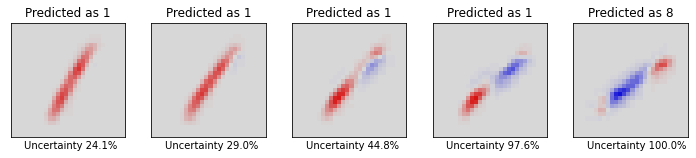

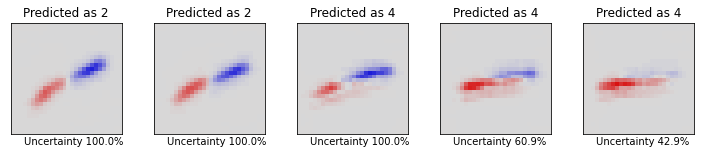

In [13]:
images = []
predicted = []
uncertainty = []
for i in range(len(rotate_imgs)):
    out, pred, uncer = uncertain_prediction_lrp_mix(model, rotate_imgs[i])
    images.append(out[0].sum(axis=0))
    predicted.append(pred)
    uncertainty.append(uncer)

MnistVisualizer.edl_heatmap_for_each_rotation(images, predicted, uncertainty)

### 3.2.1 Interpret base model with  LRP-α1β0 (Deep Taylor Decomposition)
Here **NO UNCERTAINTY** is introduced

In [14]:
from nn_interpretability.interpretation.lrp.lrp_ab import LRPAlphaBeta

def prediction_lrp_mix(model, image):
    model.eval()
    image = image.to(Evidential_DL.device)
    # Consturct LRPMix
    interpretor = LRPAlphaBeta(model, 'predicted', None, 1, 0, 0)
    heatmap = interpretor.interpret(image)
    predicted = interpretor.get_class()
    logits = model(image)
    evd = F.relu(logits)
    alpha = evd + 1
    return heatmap.detach().cpu().numpy(), predicted

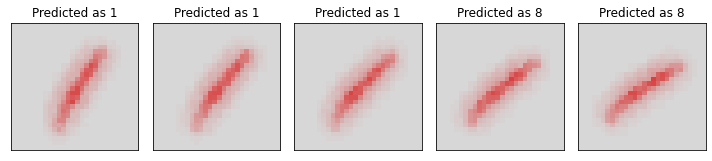

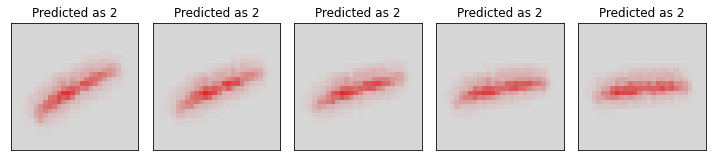

In [15]:
images = []
predicted = []
for i in range(len(rotate_imgs)):
    out, pred = prediction_lrp_mix(model_no_uncertain, rotate_imgs[i])
    images.append(out[0].sum(axis=0))
    predicted.append(pred)

MnistVisualizer.edl_heatmap_for_each_rotation(images, predicted, None)

### 3.2.2 Interpret evidential deep learning mode with  LRP-α1β0 (Deep Taylor Decomposition)

In [16]:

def uncertain_all_lrp_ab(model, image, T=1000):
    model.eval()
    image = image.to(Evidential_DL.device)
    # Consturct LRPMix
    interpretor = LRPAlphaBeta(model, 'predicted', None, 1, 0, 0)
    heatmap = interpretor.interpret(image)
    predicted = interpretor.get_class()
    logits = model(image)
    evd = F.relu(logits)
    alpha = evd + 1
    uncertainty = logits.size(1) / torch.sum(alpha, dim=1, keepdim=True)
    return heatmap.detach().cpu().numpy(), predicted, uncertainty.cpu().item()

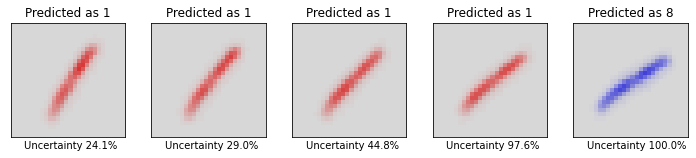

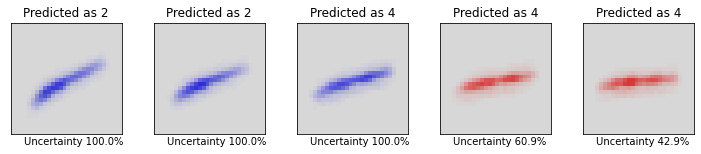

In [17]:
images = []
predicted = []
uncertainty = []
for i in range(len(rotate_imgs)):
    out, pred, uncer = uncertain_all_lrp_ab(model, rotate_imgs[i])
    images.append(out[0].sum(axis=0))
    predicted.append(pred)
    uncertainty.append(uncer)

MnistVisualizer.edl_heatmap_for_each_rotation(images, predicted, uncertainty)